In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [45]:
RDS_data = pd.read_csv("RDS_data.csv", index_col=0)
RDS_data_clean = pd.read_csv("RDS_data_cleaned.csv", index_col=0)
RDS_data_untransformed = pd.read_csv("RDS_data_pre_transform.csv", index_col=0)

In [79]:
paid_back = RDS_data_untransformed['loan_amount'] - RDS_data_untransformed['total_payment']
percentage_paid_back = (paid_back / RDS_data_untransformed['funded_amount']) * 100

Text(0.5, 0, '% of funded amount paid back')

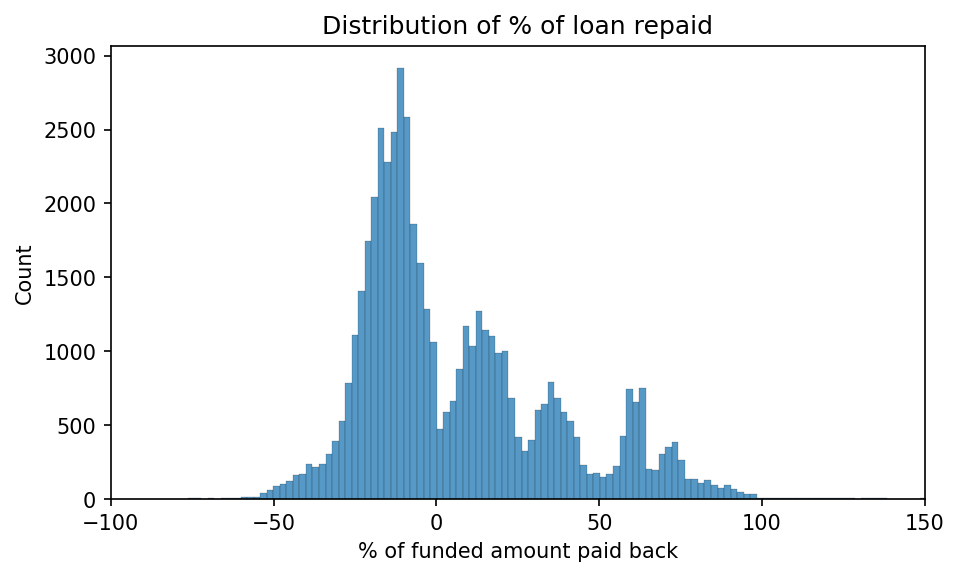

In [64]:
plt.figure(figsize=(7,4),dpi=150)
sns.histplot(percentage_paid_back)
plt.title('Distribution of % of loan repaid')
plt.xlim(-100,150)
plt.xlabel('% of funded amount paid back')

# plt.yscale('log')

In [75]:
percent_inv_recovered = (RDS_data_untransformed['funded_amount_inv'].sum() - RDS_data_untransformed['total_payment_inv'].sum())/RDS_data_untransformed['funded_amount_inv'].sum()*100
print(f"Percentage of investor funds recovered: {round(percent_inv_recovered,2)}%")

Percentage of investor funds recovered: 7.76%


In [76]:
percent_tot_recovered = (RDS_data_untransformed['funded_amount'].sum() - RDS_data_untransformed['total_payment'].sum())/RDS_data_untransformed['funded_amount'].sum()*100
print(f"Percentage of total funds recovered: {round(percent_inv_recovered,2)}%")

Percentage of total funds recovered: 7.76%


In [97]:
data.transpose()

,0,1,2,3,4,5,6,7,8,9,...,54172,54173,54175,54178,54188,54190,54199,54203,54204,54221
loan_id,38676116,38656203,38656154,38656128,38656121,38656111,38656110,38656067,38656063,38656052,...,121673,120525,120374,120215,55742,123133,55521,185352,122637,395632
member_id,41461848,41440010,41439961,41439934,41439927,41439917,41439916,41439872,41439868,41439857,...,121283,120227,119635,118760,114426,114358,107577,105254,104675,91027
loan_amount,8000,13200,16000,15000,15000,2525,6675,26500,10000,10000,...,4500,4000,2000,4000,7000,11050,1000,6000,4000,5500
funded_amount,8000.0,13200.0,16000.0,15000.0,15000.0,2525.0,6675.0,26500.0,10000.0,13247.25,...,4500.0,4000.0,2000.0,4000.0,7000.0,11050.0,1000.0,6000.0,4000.0,5500.0
funded_amount_inv,8000.0,13200.0,16000.0,15000.0,15000.0,2525.0,6675.0,26200.0,10000.0,10000.0,...,3000.0,1475.0,475.0,3575.0,672.803839,1175.0,0.0,502.69,1550.0,5450.0
int_rate,7.49,6.99,7.49,14.31,6.03,11.44,21.99,19.99,12.99,8.19,...,8.07,10.91,8.7,7.43,10.71,15.96,16.08,9.64,7.75,13.16
installment,248.82,407.52,497.63,514.93,456.54,83.2,254.89,701.95,227.48,314.25,...,141.15,130.79,63.32,124.31,228.22,388.28,35.2,192.6,124.89,185.74
loan_grade,A,A,A,C,A,B,E,E,C,A,...,A,C,B,A,B,F,F,B,A,C
loan_sub_grade,A4,A3,A4,C4,A1,B4,E5,E3,C2,A5,...,A4,C3,B1,A2,B5,F4,F2,B4,A3,C3
employment_length,5,9,8,1,15,1,0,1,1,15,...,1,1,1,1,1,3,1,1,1,1


In [100]:
data = RDS_data_untransformed
data.dtypes.value_counts()

float64    21
object     12
int64      11
bool        1
dtype: int64

In [101]:
RDS_data.dtypes.value_counts()

float64    20
object     15
int64       8
dtype: int64

In [94]:
data['mths_since_last_record']

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
54190    0.0
54199    NaN
54203    0.0
54204    0.0
54221    NaN
Name: mths_since_last_record, Length: 51377, dtype: float64

In [87]:
six_months_ahead = pd.Timestamp.today() + pd.DateOffset(months=6)
active_loans_6_months = data[(data['issue_date'] < six_months_ahead) & (data['36 months'])]


TypeError: '<' not supported between instances of 'str' and 'Timestamp'

<AxesSubplot:ylabel='Count'>

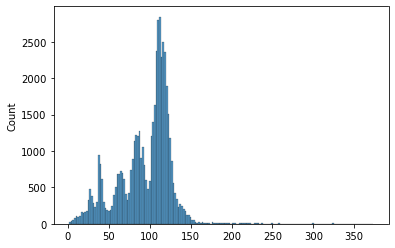

In [49]:
# Assuming '36 months' column exists as a boolean term indicator
# 'loan_start_date', 'installment', 'next_payment_date', 'amount_due'

# Filter for loans active within the next 6 months
six_months_ahead = pd.Timestamp.today() + pd.DateOffset(months=6)
active_loans_6_months = data[(data['loan_start_date'] < six_months_ahead) & (data['36 months'])]

# Calculate future payments for the next 6 months
active_loans_6_months['remaining_payments'] = 6 - (pd.Timestamp.today().month - active_loans_6_months['loan_start_date'].dt.month)
active_loans_6_months['repayment_amount_6_months'] = active_loans_6_months['installment'] * active_loans_6_months['remaining_payments']

# Summarize relevant metrics
summary_6_months = active_loans_6_months[['loan_start_date', 'amount_due', 'next_payment_date', 'repayment_amount_6_months']]


In [50]:
pd.Timestamp.now()

Timestamp('2023-11-23 19:27:14.577043')

In [51]:
six_months_payments = df[df['next_payment_date'] <= pd.Timestamp.now() + pd.DateOffset(months=6)]

# Calculate the projected percentage of recovery in the next 6 months
# projected_recovery_percentage = (six_months_payments['total_payments'].sum() / df['funded_amount'].sum()) * 100


TypeError: '<=' not supported between instances of 'str' and 'Timestamp'

In [39]:
RDS_data_clean.isnull().sum()[RDS_data.isnull().sum()>10000]

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [103]:
aksjbd = pd.read_csv('RDS_data_pre_transform.csv',index_col=0)

In [104]:
aksjbd['funded_amount'].isnull().sum()

0